<h2 style='background:#FA497A; border:0; color:white'><center>Text Analysis<center></h2>

1. Representing text as numerical data
2. Reading a text-based dataset into pandas
3. Vectorizing our dataset
4. Building and evaluating a model
5. Comparing models
6. Examining a model for further insight
7. Practicing this workflow on another dataset
8. Tuning the vectorizer (discussion)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

<h2 style='background:#F5DA81; border:0; color:#FBF8EF; text-align:center'>Representing text as numerical data</h2>
    
<h5 style='background:#F2F5A9; padding:3%; color:black;'>CountVectorizer : Text를 분리하고 각 단어의 개수를 계산해서 사전형태로 표현</h5>

In [2]:
# example text for model training (SMS messages)
simple_train = ['call you tonight', 'Call me a cab', 'Please call me... PLEASE!']

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()

# learn the 'vocabulary' of the training data (occurs in-place)
vect.fit(simple_train)

vect.get_feature_names_out()

array(['cab', 'call', 'me', 'please', 'tonight', 'you'], dtype=object)

In [4]:
# Transform training data into 'document-term matrix'
simple_train_dtm = vect.transform(simple_train)
simple_train_dtm

<3x6 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [5]:
simple_train_dtm.toarray()

array([[0, 1, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 0],
       [0, 1, 1, 2, 0, 0]])

In [6]:
pd.DataFrame(simple_train_dtm.toarray(), columns=vect.get_feature_names_out())

,cab,call,me,please,tonight,you
0,0,1,0,0,1,1
1,1,1,1,0,0,0
2,0,1,1,2,0,0


<h5 style='background:#F2F5A9; padding:3%; color:black;'>
  문단은 문서당 하나의 행과 문단에서 발생하는 토큰(예: 단어)당 하나의 열을 갖는 행렬로 표현될 수 있습니다.

 <br>벡터화를 텍스트 문서 모음을 숫자 특징 벡터로 바꾸는 일반적인 과정이라고 합니다. 이 특정 전략(토큰화, 셈 및 정규화)을 단어의 가방 또는 "n-그램의 가방" 표현이라고 합니다. 문서는 문서에 있는 단어의 상대적인 위치 정보를 완전히 무시한 채 단어의 존재 및 개수로만 설명됩니다. </h5>

In [7]:
print(type(simple_train_dtm))

print(simple_train_dtm)

<class 'scipy.sparse._csr.csr_matrix'>
  (0, 1)	1
  (0, 4)	1
  (0, 5)	1
  (1, 0)	1
  (1, 1)	1
  (1, 2)	1
  (2, 1)	1
  (2, 2)	1
  (2, 3)	2


In [8]:
simple_test = ["please don't call me"]

In [9]:
simple_test_dtm = vect.transform(simple_test)
simple_test_dtm.toarray()

array([[0, 1, 1, 1, 0, 0]])

In [10]:
pd.DataFrame(simple_test_dtm.toarray(), columns=vect.get_feature_names_out())

,cab,call,me,please,tonight,you
0,0,1,1,1,0,0


📋 Summary:
- vect.fit(train) **learns the vocabulary** of the training data
- vect.transform(train) uses the **fitted vocabulary** to build a document-term matrix from the training data
- vect.transform(test) uses the **fitted vocabulary** to build a document-term matrix from the testing data (and ignores tokens it hasn't seen before)

<h2 style='background:#F5DA81; border:0; color:#FBF8EF; text-align:center'>Reading a text-based dataset into pandas</h2>

In [11]:
sms = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv", encoding='latin-1')
# sms.columns = ["keyword", "location", "text"]
sms.drop("id", axis=1, inplace=True)
sms.head()

,keyword,location,text,target
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [12]:
print(sms.describe(include='object'))

           keyword location                                               text
count         7552     5080                                               7613
unique         221     3341                                               7503
top     fatalities      USA  11-Year-Old Boy Charged With Manslaughter of T...
freq            45      104                                                 10


<h2 style='background:#F5DA81; border:0; color:#FBF8EF; text-align:center'>🔍 Exploratory Data Analysis (EDA)</h2>

In [13]:
sms.groupby('target').describe()

keyword                          location                        text  \
         count unique          top freq    count unique       top freq count   
target                                                                         
0         4323    218  body%20bags   40     2884   2142  New York   55  4342   
1         3229    220   derailment   39     2196   1513       USA   67  3271   

                                                                       
       unique                                                top freq  
target                                                                 
0        4315  The Prophet (peace be upon him) said 'Save you...    4  
1        3206  11-Year-Old Boy Charged With Manslaughter of T...   10

In [14]:
sms['message_len'] = sms.text.apply(len)
sms.head()

,keyword,location,text,target,message_len
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


Text(0.5, 0, 'Message Length')

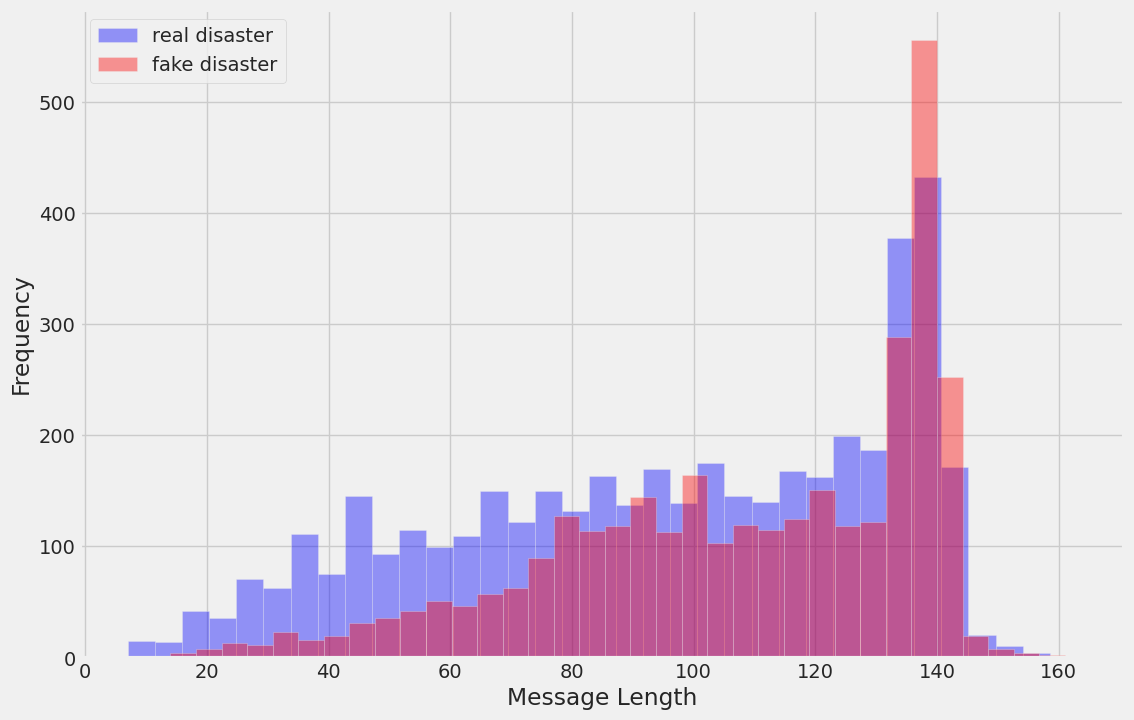

In [15]:
plt.figure(figsize=(12, 8))

sms[sms.target == 0].message_len.plot(bins=35, kind='hist', color='blue', 
                                       label='real disaster', alpha=0.4)
sms[sms.target == 1].message_len.plot(bins=35, kind='hist', color='red', 
                                       label='fake disaster', alpha=0.4)
plt.legend()
plt.xlabel("Message Length")

In [16]:
sms[sms.target==1].describe()

,target,message_len
count,3271.0,3271.000000
mean,1.0,108.444207
std,0.0,29.511567
min,1.0,14.000000
25%,1.0,88.000000
50%,1.0,115.000000
75%,1.0,136.000000
max,1.0,161.000000


In [17]:
sms[sms.target==0].describe()

,target,message_len
count,4342.0,4342.000000
mean,0.0,95.981345
std,0.0,36.100118
min,0.0,7.000000
25%,0.0,68.000000
50%,0.0,101.000000
75%,0.0,130.000000
max,0.0,163.000000


<h2 style='background:#F5DA81; border:0; color:#FBF8EF; text-align:center'>📑 Text Pre-processing</h2>

가장 먼저, text로 되어 있는 데이터를 분류 모델이 학습할 수 있는 수치형 변수로 변환해줘야 한다.
간단한 방법은 각 단어를 하나의 숫자로 지정하는 **bag-of-words**로 접근하는 방법이 있다.

여기서 우리는 날 것의 text (sequence of characters)를 vector로 변환한다. (sequence of numbers)

먼저, text를 개별 단어의 리스트로 분리한 뒤, 'the', 'a'와 같은 불용어를 제거한다.

이를 위해서 기본이 되는 파이썬 문자열 전처리 모듈인 NLTK 라이브러리를 사용한다.

일단 구두점을 활용하여 단어를 분리한다.

In [18]:
import string
from nltk.corpus import stopwords

def text_process(mess):
    '''
    1. 모든 구두점을 제거한다.
    2. 모든 불용어를 제거한다.
    3. 전처리된 text의 리스트를 반환한다.
    '''
    
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

In [19]:
sms.head()

,keyword,location,text,target,message_len
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


In [20]:
sms['clean_msg'] = sms.text.apply(text_process)

sms.head()

,keyword,location,text,target,message_len,clean_msg
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,Deeds Reason earthquake May ALLAH Forgive us
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,Forest fire near La Ronge Sask Canada
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,residents asked shelter place notified officer...
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,13000 people receive wildfires evacuation orde...
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,got sent photo Ruby Alaska smoke wildfires pou...


In [21]:
type(stopwords.words('english'))

list

In [22]:
from collections import Counter

words = sms[sms.target == 1].clean_msg.apply(lambda x: [word.lower() for word in x.split()])
real = Counter()

for msg in words:
    real.update(msg)
    
print(real.most_common(50))

[('fire', 178), ('news', 136), ('via', 121), ('disaster', 117), ('california', 111), ('suicide', 110), ('police', 107), ('amp', 106), ('people', 105), ('killed', 93), ('like', 92), ('hiroshima', 86), ('storm', 85), ('crash', 84), ('fires', 84), ('us', 81), ('families', 81), ('train', 79), ('emergency', 76), ('buildings', 75), ('bomb', 74), ('two', 71), ('mh370', 71), ('nuclear', 70), ('attack', 69), ('video', 69), ('wildfire', 69), ('get', 66), ('accident', 66), ('bombing', 66), ('one', 65), ('northern', 64), ('burning', 64), ('dead', 63), ('pm', 62), ('legionnaires', 62), ('bomber', 60), ('homes', 58), ('car', 57), ('still', 57), ('war', 57), ('new', 56), ('atomic', 56), ('obama', 54), ('fatal', 54), ('years', 53), ('collapse', 51), ('may', 50), ('forest', 50), ('debris', 50)]


In [23]:
words = sms[sms.target==0].clean_msg.apply(lambda x: [word.lower() for word in x.split()])
fake = Counter()

for msg in words:
    fake.update(msg)
    
print(fake.most_common(50))

[('like', 253), ('amp', 192), ('new', 168), ('get', 163), ('one', 128), ('body', 112), ('via', 99), ('would', 97), ('video', 96), ('people', 91), ('love', 89), ('know', 85), ('back', 84), ('time', 83), ('us', 83), ('got', 83), ('see', 82), ('cant', 81), ('emergency', 81), ('full', 81), ('day', 78), ('youtube', 76), ('going', 75), ('still', 72), ('fire', 72), ('go', 67), ('want', 67), ('good', 67), ('think', 66), ('3', 64), ('man', 62), ('world', 62), ('lol', 61), ('rt', 60), ('life', 60), ('youre', 58), ('first', 58), ('news', 57), ('last', 56), ('burning', 56), ('really', 55), ('way', 55), ('need', 55), ('make', 54), ('work', 54), ('best', 53), ('let', 52), ('much', 51), ('many', 51), ('even', 51)]


<h2 style='background:#F5DA81; border:0; color:#FBF8EF; text-align:center'>🧮 Vectorization¶</h2>

bag-of-model을 사용하기 전, 아래의 단계를 거칩니다.

1. 각 단어에 해당하는 term-frequency를 계산합니다. (text에서 단어가 얼마나 나왔는지 개수)
2. 빈번한 토큰의 가중치가 낮아지도록 카운트의 가중치를 측정합니다. (inverse document frequency)
3. text의 길이 피처의 vector를 unit length 단위로 Normalization 해줍니다. (L2 Norm)

이를 위해 먼저 sklearn의 CountVectorizer를 사용합니다.
- 이 라이브러리는 문장의 단어를 Count해줍니다.

In [24]:
from sklearn.model_selection import train_test_split

X = sms.clean_msg
y = sms.target

print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 77)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7613,) (7613,)
(5709,) (1904,) (5709,) (1904,)


In [25]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
vect.fit(X_train)

X_train_dtm = vect.transform(X_train)

print(type(X_train_dtm), X_train_dtm.shape)

X_test_dtm = vect.transform(X_test)
print(type(X_test_dtm), X_test_dtm.shape)

<class 'scipy.sparse._csr.csr_matrix'> (5709, 18311)
<class 'scipy.sparse._csr.csr_matrix'> (1904, 18311)


In [26]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_dtm)
tfidf_transformer.transform(X_train_dtm)

<5709x18311 sparse matrix of type '<class 'numpy.float64'>'
	with 54993 stored elements in Compressed Sparse Row format>

<h2 style='background:#F5DA81; border:0; color:#FBF8EF; text-align:center'>🤖 Building and evaluating a model</h2>

In [27]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [28]:
%time nb.fit(X_train_dtm, y_train)

CPU times: user 7.35 ms, sys: 1.06 ms, total: 8.42 ms
Wall time: 7.52 ms


MultinomialNB()

In [29]:
from sklearn import metrics

y_pred_class = nb.predict(X_test_dtm)

print("=======Accuracy Score===========")
print(metrics.accuracy_score(y_test, y_pred_class))

print("=======Confision Matrix===========")
metrics.confusion_matrix(y_test, y_pred_class)

=======Accuracy Score===========
0.7904411764705882
=======Confision Matrix===========


array([[922, 171],
       [228, 583]])

<h2 style='background:#F5DA81; border:0; color:#FBF8EF; text-align:center'>📊 Comparing models</h2>

In [30]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='liblinear')

%time logreg.fit(X_train_dtm, y_train)

CPU times: user 134 ms, sys: 96.3 ms, total: 230 ms
Wall time: 66.7 ms


LogisticRegression(solver='liblinear')

In [32]:
y_pred = logreg.predict(X_test_dtm)

y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([0.2285224 , 0.49953591, 0.92983743, ..., 0.96532319, 0.14628626,
       0.83731025])

In [33]:
y_pred_class = nb.predict(X_test_dtm)

print("=======Accuracy Score===========")
print(metrics.accuracy_score(y_test, y_pred_class))

print("=======Confision Matrix===========")
metrics.confusion_matrix(y_test, y_pred_class)

=======Accuracy Score===========
0.7904411764705882
=======Confision Matrix===========


array([[922, 171],
       [228, 583]])

<h2 style='background:#F5DA81; border:0; color:#FBF8EF; text-align:center'>🧮 Tuning the vectorizer</h2>

In [34]:
vect

CountVectorizer()

📌 However, the vectorizer is worth tuning, just like a model is worth tuning! Here are a few parameters that you might want to tune:

- 📌 stop_words: string {'english'}, list, or None (default)
    - If 'english', a built-in stop word list for English is used.
    - If a list, that list is assumed to contain stop words, all of which will be removed from the resulting tokens.
    - If None, no stop words will be used.

In [35]:
vect = CountVectorizer(stop_words='english')

- 📌 ngram_range: tuple (min_n, max_n), default=(1, 1)
    - The lower and upper boundary of the range of n-values for different n-grams to be extracted.
    - All values of n such that min_n <= n <= max_n will be used.

In [ ]:
vect = CountVectorizer(ngram_range=(1, 2))

- 📌 max_df: float in range [0.0, 1.0] or int, default=1.0
    - When building the vocabulary, ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words).
    - If float, the parameter represents a proportion of documents.
    - If integer, the parameter represents an absolute count.

In [ ]:
# ignore terms that appear in more than 50% of the documents
vect = CountVectorizer(max_df=0.5)

- 📌 min_df: float in range [0.0, 1.0] or int, default=1
    - When building the vocabulary, ignore terms that have a document frequency strictly lower than the given threshold. (This value is also called "cut-off" in the literature.)
    - If float, the parameter represents a proportion of documents.
    - If integer, the parameter represents an absolute count.

In [ ]:
vect = CountVectorizer(min_df=2)